In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from transformers import BertTokenizer, BertForSequenceClassification, RobertaTokenizer, RobertaForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from transformers import Trainer, TrainingArguments
import torch
from datasets import Dataset
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import seaborn as sns
#TODO: CHANGE THE FOLDER and SAVE PATHS
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:128'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # Use only GPU 0
# Check if the GPU is being used
if torch.cuda.is_available():
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("No GPU available, using CPU instead.")
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
# Load Data
folder_path_train = "data/cleaned/train"
folder_path_test = "data/cleaned/test"
names = ["Facebook", "Reddit", "Twitter", "Youtube"]
dfs_train = {n: pd.read_csv(os.path.join(folder_path_train, f"{n.lower()}_train.csv")) for n in names}
dfs_test = {n: pd.read_csv(os.path.join(folder_path_test, f"{n.lower()}_test.csv")) for n in names}



2024-06-27 16:01:58.522774: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-27 16:01:58.828593: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-27 16:02:00.237140: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-06-27 16:02:00.237272

Using GPU: NVIDIA A16


In [2]:
# Train models on one platform and test on others
def train_and_evaluate(train_name, test_names, model_name, model_class, tokenizer_class, save_path):
    # Prepare training data
    df_train = dfs_train[train_name]
    df_train['label'] = df_train['label'].astype(int)
    train_dataset = Dataset.from_pandas(df_train)

    # Tokenization
    tokenizer = tokenizer_class.from_pretrained(model_name)

    def tokenize_function(examples):
        return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=128)

    tokenized_train = train_dataset.map(tokenize_function, batched=True)
    tokenized_train = tokenized_train.remove_columns(['text'])
    tokenized_train.set_format('torch')

    # Create DataLoader
    train_loader = DataLoader(tokenized_train, batch_size=2, shuffle=True)  # Reduced batch size

    # Load and Train Model
    model = model_class.from_pretrained(model_name, num_labels=2)
    model.to(device)
    
    optimizer = AdamW(model.parameters(), lr=2e-5)
    total_steps = len(train_loader) * 3  # Assuming 3 epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    def train_model(model, train_loader, optimizer, scheduler, num_epochs=3, accumulation_steps=8):  # Increased accumulation steps
        model.train()
        for epoch in range(num_epochs):
            total_train_loss = 0

            for i, batch in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{num_epochs}")):
                inputs = {key: val.to(device) for key, val in batch.items() if key != 'label'}
                labels = batch['label'].to(device)
                outputs = model(**inputs, labels=labels)
                loss = outputs.loss / accumulation_steps
                total_train_loss += loss.item()
                loss.backward()

                if (i + 1) % accumulation_steps == 0:
                    optimizer.step()
                    scheduler.step()
                    optimizer.zero_grad()
                    torch.cuda.empty_cache()  # Clear GPU cache periodically

            avg_train_loss = total_train_loss / len(train_loader)
            print(f'Epoch {epoch + 1}/{num_epochs}')
            print(f'Train Loss: {avg_train_loss:.4f}')

    train_model(model, train_loader, optimizer, scheduler)

    # Save the model and tokenizer
    model.save_pretrained(save_path)
    tokenizer.save_pretrained(save_path)

    # Evaluate on test datasets
    results = {}
    for test_name in test_names:
        df_test = dfs_test[test_name]
        df_test['label'] = df_test['label'].astype(int)
        test_dataset = Dataset.from_pandas(df_test)

        tokenized_test = test_dataset.map(tokenize_function, batched=True)
        tokenized_test = tokenized_test.remove_columns(['text'])
        tokenized_test.set_format('torch')
        test_loader = DataLoader(tokenized_test, batch_size=2, shuffle=False)  # Reduced batch size

        def evaluate_model(model, test_loader):
            model.eval()
            predictions = []
            true_labels = []
            
            with torch.no_grad():
                for batch in tqdm(test_loader, desc="Evaluating"):
                    inputs = {key: val.to(device) for key, val in batch.items() if key != 'label'}
                    labels = batch['label'].to(device)
                    outputs = model(**inputs)
                    logits = outputs.logits
                    preds = torch.argmax(logits, dim=1).detach().cpu().numpy()
                    labels = labels.detach().cpu().numpy()
                    predictions.extend(preds)
                    true_labels.extend(labels)
            
            return true_labels, predictions

        true_labels, predictions = evaluate_model(model, test_loader)
        results[test_name] = classification_report(true_labels, predictions, output_dict=True)

        # Plot confusion matrix
        def plot_confusion_matrix(true_labels, predictions, class_names, platform_name):
            cm = confusion_matrix(true_labels, predictions)
            cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
            plt.title(f"Confusion Matrix - {platform_name}")
            plt.ylabel("Actual")
            plt.xlabel("Predicted")
            plt.show()

        plot_confusion_matrix(true_labels, predictions, ['Class 0', 'Class 1'], test_name)

    return results

Map:   0%|          | 0/1196 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/jovyan/.local/lib/python3.8/site-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training Epoch 1/3: 100%|██████████| 598/598 [00:23<00:00, 25.46it/s]


Epoch 1/3
Train Loss: 0.0648


Training Epoch 2/3: 100%|██████████| 598/598 [00:22<00:00, 26.71it/s]


Epoch 2/3
Train Loss: 0.0286


Training Epoch 3/3: 100%|██████████| 598/598 [00:22<00:00, 26.74it/s]


Epoch 3/3
Train Loss: 0.0093


Map:   0%|          | 0/3359 [00:00<?, ? examples/s]

Evaluating: 100%|██████████| 1680/1680 [00:12<00:00, 131.32it/s]


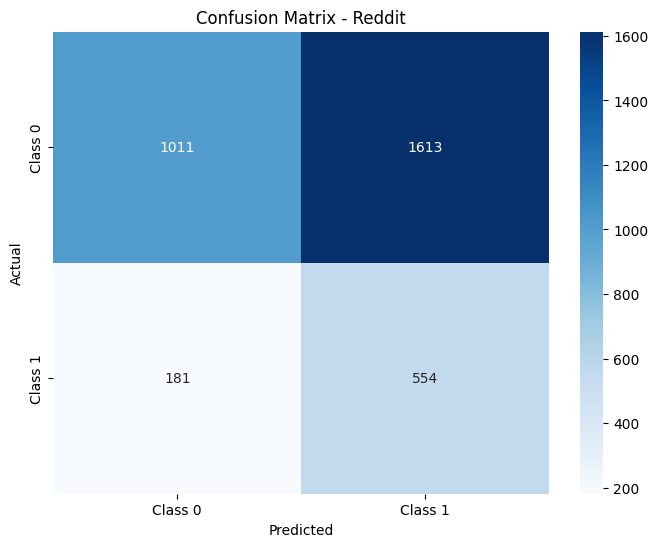

Map:   0%|          | 0/4839 [00:00<?, ? examples/s]

Evaluating: 100%|██████████| 2420/2420 [00:18<00:00, 131.10it/s]


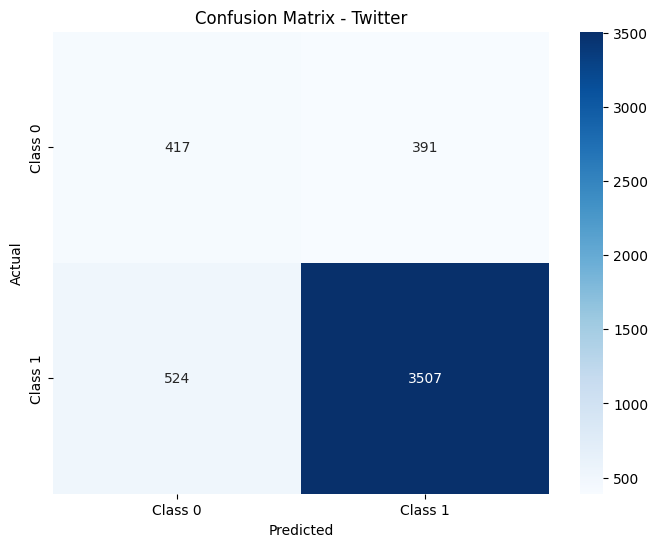

Map:   0%|          | 0/629 [00:00<?, ? examples/s]

Evaluating: 100%|██████████| 315/315 [00:02<00:00, 130.90it/s]


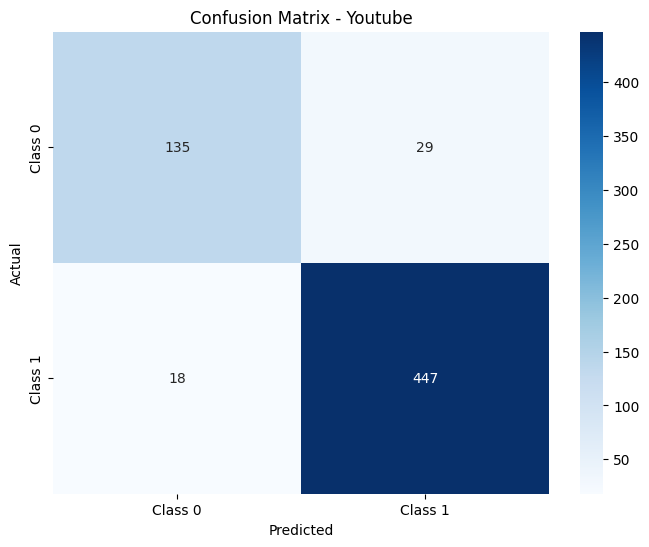

In [3]:

# Train on dataset of a platform and test on other platforms using BERT
bert_results_facebook = train_and_evaluate("Facebook", ["Reddit", "Twitter", "Youtube"], "bert-base-uncased", BertForSequenceClassification, BertTokenizer, save_path='ml/bert_model')

Map:   0%|          | 0/2512 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/jovyan/.local/lib/python3.8/site-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training Epoch 1/3: 100%|██████████| 1256/1256 [00:45<00:00, 27.67it/s]


Epoch 1/3
Train Loss: 0.0450


Training Epoch 2/3: 100%|██████████| 1256/1256 [00:46<00:00, 26.94it/s]


Epoch 2/3
Train Loss: 0.0169


Training Epoch 3/3: 100%|██████████| 1256/1256 [00:46<00:00, 27.05it/s]


Epoch 3/3
Train Loss: 0.0063


Map:   0%|          | 0/3359 [00:00<?, ? examples/s]

Evaluating: 100%|██████████| 1680/1680 [00:12<00:00, 132.83it/s]


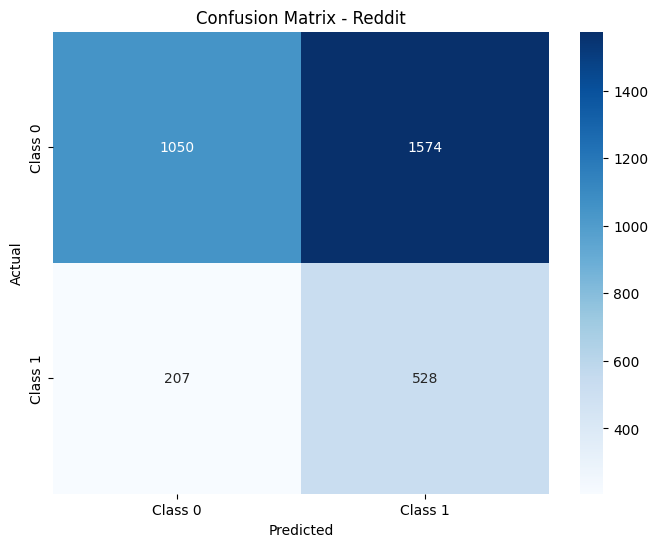

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Evaluating: 100%|██████████| 150/150 [00:01<00:00, 133.32it/s]


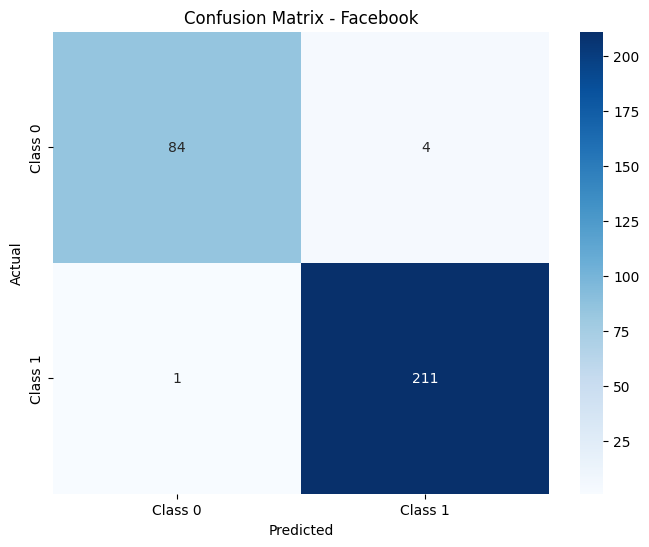

Map:   0%|          | 0/4839 [00:00<?, ? examples/s]

Evaluating: 100%|██████████| 2420/2420 [00:18<00:00, 133.03it/s]


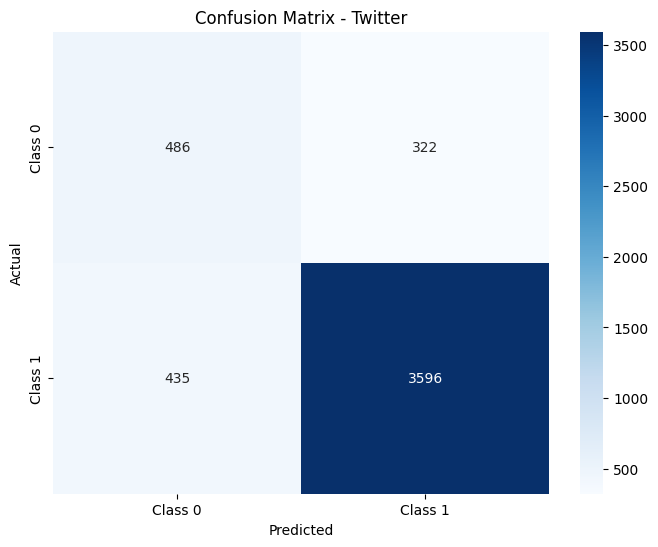

In [4]:
bert_results_youtube = train_and_evaluate("Youtube", ["Reddit", "Facebook", "Twitter"], "bert-base-uncased", BertForSequenceClassification, BertTokenizer, save_path='ml/bert_model')


Map:   0%|          | 0/19356 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/jovyan/.local/lib/python3.8/site-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training Epoch 1/3: 100%|██████████| 9678/9678 [06:31<00:00, 24.73it/s]


Epoch 1/3
Train Loss: 0.0168


Training Epoch 2/3: 100%|██████████| 9678/9678 [08:37<00:00, 18.70it/s]


Epoch 2/3
Train Loss: 0.0098


Training Epoch 3/3: 100%|██████████| 9678/9678 [11:27<00:00, 14.08it/s]


Epoch 3/3
Train Loss: 0.0058


Map:   0%|          | 0/3359 [00:00<?, ? examples/s]

Evaluating: 100%|██████████| 1680/1680 [00:12<00:00, 132.30it/s]


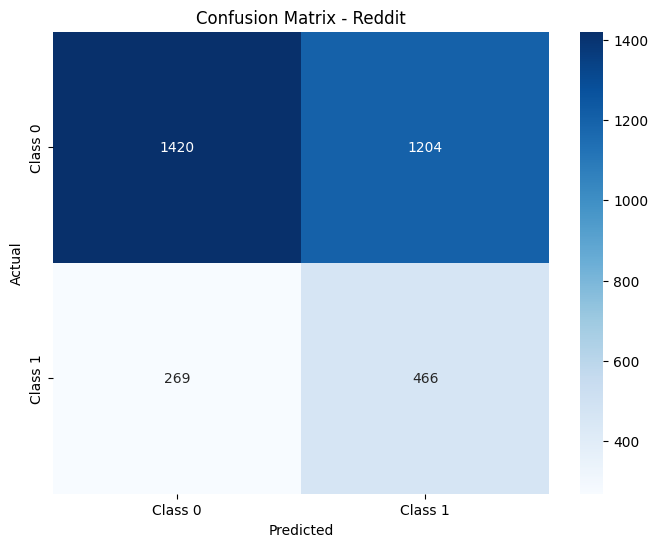

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Evaluating: 100%|██████████| 150/150 [00:01<00:00, 132.45it/s]


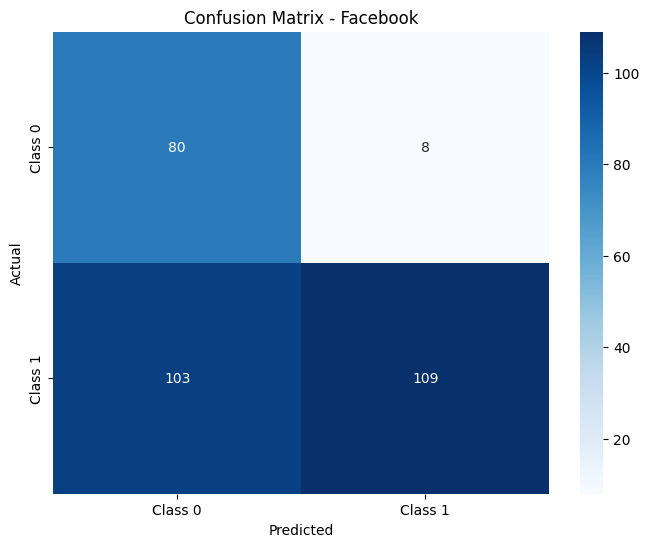

Map:   0%|          | 0/629 [00:00<?, ? examples/s]

Evaluating: 100%|██████████| 315/315 [00:02<00:00, 119.99it/s]


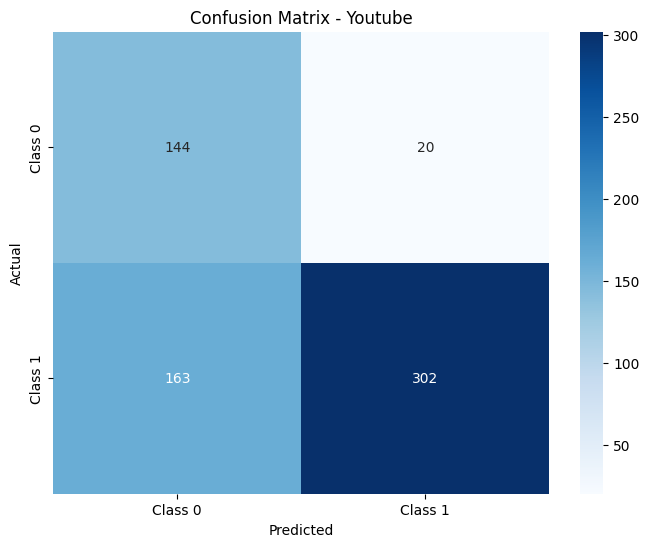

In [5]:
bert_results_twitter = train_and_evaluate("Twitter", ["Reddit", "Facebook", "Youtube"], "bert-base-uncased", BertForSequenceClassification, BertTokenizer, save_path='ml/bert_model')


In [11]:
# Save overall results to CSV
bert_results_yt = pd.DataFrame.from_dict(bert_results_youtube)
bert_results_yt.to_csv('bert_results_youtube.csv', index=True)

In [ ]:


# Function to plot performance metrics across platforms
def plot_performance(results, model_name):
    platforms = list(results.keys())
    metrics = ['support', 'precision', 'recall', 'f1-score']

    for metric in metrics:
        values = [results[platform]['weighted avg'][metric] for platform in platforms]
        plt.figure(figsize=(10, 6))
        plt.bar(platforms, values, color='skyblue')
        plt.xlabel('Platform')
        plt.ylabel(metric.capitalize())
        plt.title(f'{metric.capitalize()} across platforms for {model_name}')
        plt.ylim(0, 1)
        for i, v in enumerate(values):
            plt.text(i, v + 0.02, f"{v:.2f}", ha='center')
        plt.show()



In [ ]:
# Plot performance metrics
print("BERT Results reddit:")
plot_performance(bert_results_reddit, "BERT")

# Plot performance metrics
print("BERT Results youtube:")
plot_performance(bert_results_youtube, "BERT")

# Plot performance metrics
print("BERT Results twitter:")
plot_performance(bert_results_twitter, "BERT")
print("BERT Results facebook:")
plot_performance(bert_results_facebook, "BERT")


#print("\nRoBERTa Results:")
#plot_performance(roberta_results, "RoBERTa")